In [12]:
# Imports required for this Notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pyspark.sql import SparkSession
from datetime import datetime
from google.cloud import bigquery
from pyspark.sql.functions import col

In [2]:
def initialize_spark_session(app_name="Ethereum"):
    """Initialize and return a Spark session."""
    return SparkSession.builder.appName(app_name).getOrCreate()

def load_dataframe_from_bigquery(spark_session, table_name):
    """Load and return a DataFrame from BigQuery."""
    return spark_session.read.format("bigquery").option("table", table_name).load()

## Analysis based on transactions
#### **Objective:**
To visualize the Ethereum transaction trends over time by creating two bar plots: one showing the number of transactions occurring every month and the other displaying the average value of transactions in each month between the start and end of the dataset.

#### **Data Source:**
The data used in this analysis is fetched from the BigQuery table molten-nirvana-397215.Ethereum_project.transactions_temp. The primary fields of interest in the dataset are block_timestamp and value.

#### **Execution:**

1) Initialize the Spark session.

2) Load the transactions_temp table from BigQuery into a DataFrame.

3) Extract the year and month from the block_timestamp column.

4) Compute the monthly transaction count.

5) Compute the monthly average transaction value.

6) Visualize the results using bar plots.

#### **Methodology:**

**Initialize Spark Session:** A Spark session named EthereumAnalysis is initialized to process the data.

**Load Data:** The transactions_temp table from BigQuery is loaded into a DataFrame named transactions_df.

**Data Mapping:** The block_timestamp column from the DataFrame is used to extract the year and month for each transaction using the extract_year_month function.

**Compute Monthly Transaction Count:** The compute_monthly_transaction_count function maps each (year, month) pair to a count of 1, then aggregates these counts to compute the total number of transactions for each month.

**Compute Monthly Average Transaction Value:** The compute_monthly_avg_transaction_value function first maps each (year, month) pair to a tuple containing the count of transactions and their total value. It then aggregates these values and computes the average transaction value for each month.

**Visualization:** The results are visualized using bar plots. The first plot, monthly_transaction_count.png, shows the number of transactions for each month, while the second plot, monthly_avg_transaction_value.png, displays the average transaction value for each month.

**Output:**

Monthly Transaction Count: A bar plot named monthly_transaction_count.png that showcases the number of Ethereum transactions for each month between the start and end of the dataset.

Monthly Average Transaction Value: A bar plot named monthly_avg_transaction_value.png that illustrates the average value of Ethereum transactions for each month between the start and end of the dataset.

In [7]:
from pyspark.sql.functions import year, month

# Initialize Spark session
spark = initialize_spark_session()

# Load dataframes
transactions_df = load_dataframe_from_bigquery(spark, "molten-nirvana-397215.Ethereum_project.transactions_temp")

def initialize_spark_session(app_name="EthereumAnalysis"):
    """Initialize and return a Spark session."""
    return SparkSession.builder.appName(app_name).getOrCreate()

def extract_year_month(df):
    """Extract year and month from block_timestamp."""
    return df.select(
        year("block_timestamp").alias("year"),
        month("block_timestamp").alias("month")
    )

def compute_monthly_transaction_count(transactions_mapped):
    """Compute and return the monthly transaction count."""
    return transactions_mapped.rdd.map(lambda x: ((x.year, x.month), 1)).reduceByKey(lambda a, b: a + b)

def compute_monthly_avg_transaction_value(df):
    """Compute and return the monthly average transaction value."""
    transactions_mapped = df.select(
        year("block_timestamp").alias("year"),
        month("block_timestamp").alias("month"),
        df["value"].cast("double").alias("transaction_value")
    )
    sum_count = transactions_mapped.rdd.map(lambda x: ((x.year, x.month), (1, x.transaction_value))).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    return sum_count.mapValues(lambda x: x[1] / x[0])

# Load and map transactions
transactions_mapped = extract_year_month(transactions_df)

# Compute results
monthly_transaction_count = compute_monthly_transaction_count(transactions_mapped)
monthly_transaction_count.collect()
monthly_avg_transaction_value = compute_monthly_avg_transaction_value(transactions_df)
monthly_avg_transaction_value.collect()

Exception in thread "serve RDD 19 with partitions 0" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


[((2022, 12), 1.166710370398918e+18),
 ((2023, 4), 1.2756303910159357e+18),
 ((2023, 5), 1.2343629616287777e+18),
 ((2023, 7), 9.552449634523561e+17),
 ((2023, 6), 1.3462346073121687e+18),
 ((2023, 1), 1.1570095146506834e+18),
 ((2023, 3), 1.494498281122842e+18),
 ((2023, 2), 1.1603661671932068e+18),
 ((2022, 11), 2.2991099242637338e+18),
 ((2022, 10), 1.2272452486815734e+18),
 ((2022, 9), 1.9345369506927836e+18),
 ((2023, 8), 9.756280623647105e+17),
 ((2023, 9), 1.0772160272054551e+18)]

In [9]:
monthly_transaction_count.collect()

[((2022, 12), 32114430),
 ((2023, 4), 30166979),
 ((2023, 5), 33518547),
 ((2023, 7), 31474016),
 ((2023, 6), 31628242),
 ((2023, 1), 31861364),
 ((2023, 3), 33108538),
 ((2023, 2), 29793399),
 ((2022, 11), 31271090),
 ((2022, 10), 34122529),
 ((2022, 9), 13662648),
 ((2023, 8), 31954474),
 ((2023, 9), 19265751)]

In [32]:
monthly_transaction_count_df = pd.DataFrame(monthly_transaction_count, columns=["Date", "Total Transaction count"])
monthly_transaction_count_df['Date'] = monthly_transaction_count_df['Date'].apply(lambda x: f"{x[0]}-{x[1]:02}")

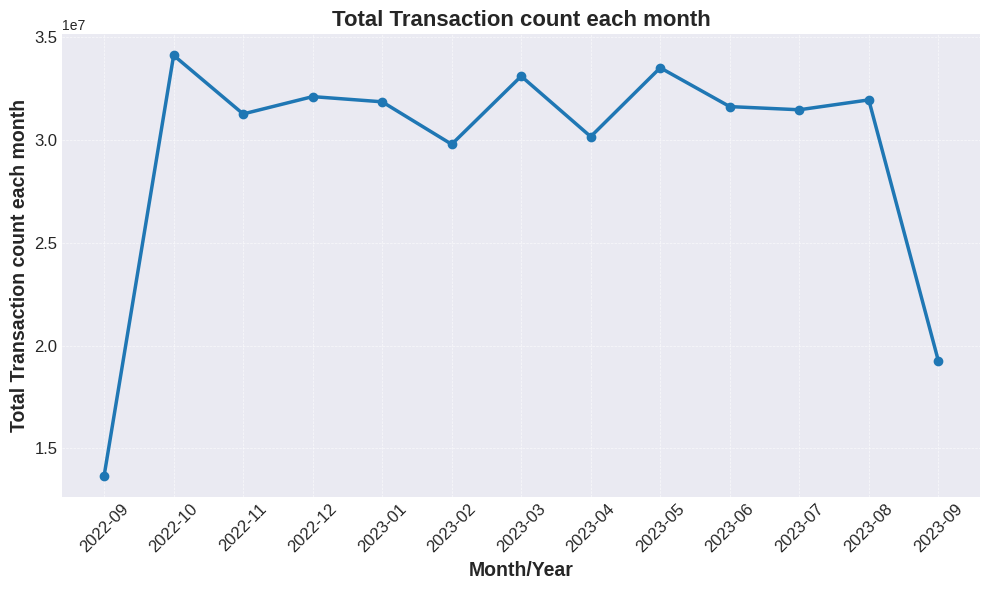

In [33]:
# Setting a style
plt.style.use('seaborn-darkgrid')

# Creating a color palette
palette = plt.get_cmap('tab10')

fig, ax = plt.subplots(figsize=( 10,6))

# Plotting with improved aesthetics
ax.plot(monthly_transaction_count_df["Date"], monthly_transaction_count_df["Total Transaction count"], marker='o', color=palette(0), linewidth=2.5)
ax.set_xlabel("Month/Year", fontsize=14, fontweight='bold')
ax.set_ylabel("Total Transaction count each month", fontsize=14, fontweight='bold')
ax.set_title("Total Transaction count each month", fontsize=16, fontweight='bold')

# Adding a background grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Setting the font size for tick labels for better visibility
ax.tick_params(axis='both', which='major', labelsize=12)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [29]:
monthly_avg_transaction_value_df = pd.DataFrame(monthly_avg_transaction_value, columns=["Date", "Average Transaction Value"])
monthly_avg_transaction_value_df['Date'] = monthly_avg_transaction_value_df['Date'].apply(lambda x: f"{x[0]}-{x[1]:02}")

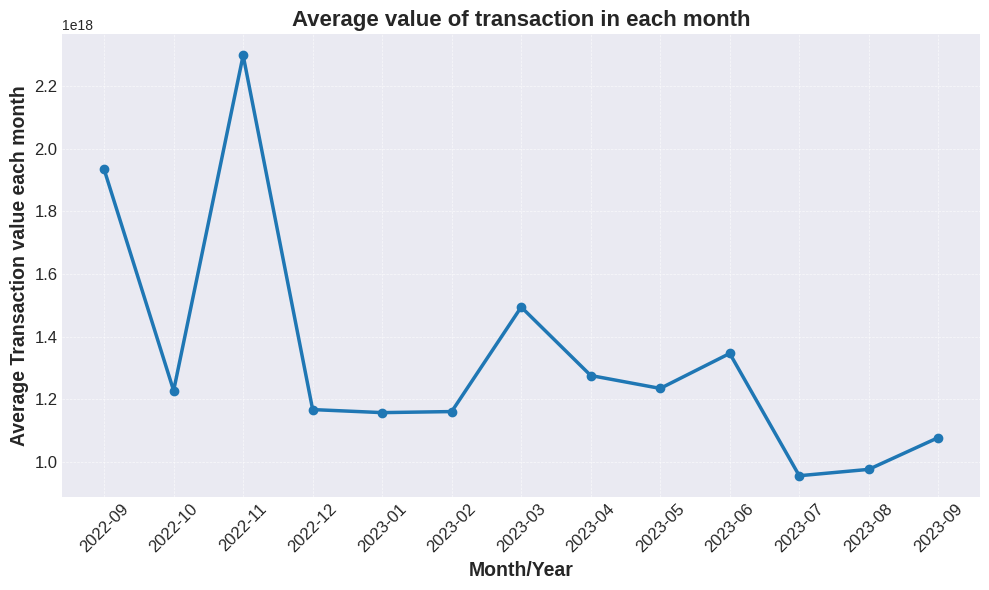

In [30]:
# Setting a style
plt.style.use('seaborn-darkgrid')

# Creating a color palette
palette = plt.get_cmap('tab10')

fig, ax = plt.subplots(figsize=( 10,6))

# Plotting with improved aesthetics
ax.plot(monthly_avg_transaction_value_df["Date"], monthly_avg_transaction_value_df["Average Transaction Value"], marker='o', color=palette(0), linewidth=2.5)
ax.set_xlabel("Month/Year", fontsize=14, fontweight='bold')
ax.set_ylabel("Average Transaction value each month", fontsize=14, fontweight='bold')
ax.set_title("Average value of transaction in each month", fontsize=16, fontweight='bold')

# Adding a background grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Setting the font size for tick labels for better visibility
ax.tick_params(axis='both', which='major', labelsize=12)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Top Ten Most Popular Services

#### **Objectives:**
To evaluate the top 10 smart contracts by total Ether received. This involves joining the address field in the contracts dataset with the to_address in the transactions dataset to ascertain the total ether each contract has received.

**Data Source:**
The data for this analysis was sourced from two datasets stored in BigQuery. The highlighted fields in the data schema were used in the source code to derive the results.

**transactions.csv:** [hash, nonce, block_hash, block_number, transaction_index, from_address, **to_address, value**, gas, gas_price, input, block_timestamp, max_fee_per_gas, max_priority_fee_per_gas, transaction_type]

**contracts.csv:** [**address**, bytecode, function_sighashes, is_erc20, is_erc721, block_number]

**Methodology:**

**Initialize Spark session:** A Spark session named "Ethereum" is initiated.

**Fetch transactions and contracts data:** The datasets transactions.csv and contracts.csv are fetched from BigQuery.

**Mapping transactions and contracts:** The transactions dataset is mapped to extract the Ethereum to_address and transaction value. The contracts dataset is mapped to associate each contract address.

**Reduce and join transactions with contracts:** Transactions are grouped by address and then joined with the contracts dataset. The resultant dataset provides the address and total transaction value. The top 10 smart contracts, based on their total transaction value, are then extracted.

**Output:**
The top 10 smart contracts by total Ether received are determined. The specific values can be viewed in the top_smart_contracts.txt file.

In [4]:
def get_top_smart_contracts(transactions_df, contracts_df, top_n=10):
    """Evaluate and return the top N smart contracts by total Ether received."""
    
    # Extract relevant fields and cast types
    transactions_mapped = transactions_df.rdd.map(lambda x: (x.to_address, int(x.value)))
    
    # Aggregate transactions by address
    transactions_aggregated = transactions_mapped.reduceByKey(lambda x, y: x + y)
    
    # Map contracts for join operation
    contracts_mapped = contracts_df.rdd.map(lambda x: (x.address, 1))
    
    # Join transactions with contracts on address
    joined_data = transactions_aggregated.join(contracts_mapped)
    
    # Extract address and total transaction value
    address_value = joined_data.map(lambda x: (x[0], x[1][0]))
    
    # Get top N contracts by transaction value
    top_smart_contracts = address_value.takeOrdered(top_n, key=lambda x: -x[1])
    
    return top_smart_contracts

# Initialize Spark session
spark = initialize_spark_session()

# Load dataframes
transactions_df = load_dataframe_from_bigquery(spark, "molten-nirvana-397215.Ethereum_project.transactions_temp")
contracts_df = load_dataframe_from_bigquery(spark, "molten-nirvana-397215.Ethereum_project.contracts")

# Evaluate top 10 smart contracts
top_10_contracts = get_top_smart_contracts(transactions_df, contracts_df)
for contract in top_10_contracts:
    print(f"{contract[0]}: {contract[1]:,}")

23/09/26 15:22:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b: 5,455,625,327,065,591,384,203,560
0x1111111254eeb25477b68fb85ed929f73a960582: 3,925,533,218,024,524,653,406,525
0x0000000000a39bb272e79075ade125fd351887ac: 2,745,765,653,390,581,674,457,826
0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad: 2,611,230,651,053,409,643,679,960
0x32400084c286cf3e17e7b677ea9583e60a000324: 1,372,715,835,201,654,312,940,217
0xd322a49006fc828f9b5b37ab215f99b4e5cab19c: 1,056,075,545,541,509,374,039,795
0x000000000000ad05ccc4f10045630fb830b95127: 1,031,397,776,111,823,544,497,321
0x0087bb802d9c0e343f00510000729031ce00bf27: 908,261,456,894,000,000,000,000
0xe8cfad4c75a5e1caf939fd80afcf837dde340a69: 712,838,833,459,000,000,000,000
0xa397a8c2086c554b531c02e29f3291c9704b00c7: 507,280,516,055,440,766,339,642


## Top 10 Miners 
### **Objective:**
To identify the top 10 miners based on the size of the blocks they've mined. The methodology involves aggregating the block sizes for each miner and then sorting to determine the top miners.

### **Data Source:**
The data for this analysis is sourced from BigQuery. The primary table used is blocks from the dataset molten-nirvana-397215.Ethereum_project.

**blocks.csv schema:** [number, hash, parent_hash, nonce, sha3_uncles, logs_bloom, transactions_root, state_root, receipts_root, miner, difficulty, total_difficulty, size, extra_data, gas_limit, gas_used, timestamp, transaction_count, base_fee_per_gas]

**Execution:**
To execute the analysis, run the Python script named top-miners.py.

### **Methodology:**

**Spark Session Initialization:** A Spark session is initialized with the application name "Ethereum".

**Data Loading:** The blocks table is loaded from BigQuery into a DataFrame.

**Data Transformation:** The data is transformed to extract the miner and size fields. Each row in the DataFrame represents a block mined by a miner and its size.

**Aggregation:** The block sizes are aggregated for each miner using the reduceByKey function.

**Sorting and Selection:** The aggregated data is then sorted by block size in descending order, and the top 10 miners are selected.

**Output:** The top 10 miners, along with their aggregated block sizes, are printed to the console. This list is printed to the console in the format: Miner: [miner_address], Total Block Size: [total_block_size].


In [6]:
# Top 10 Miners by block size

def get_top_miners_by_block_size(blocks_df, top_n=10):
    """Evaluate and return the top N miners by block size."""
    
    # Transform blocks data to extract miner and block size
    blocks_transformed = blocks_df.rdd.map(lambda x: (x.miner, x.size))
    
    # Aggregate block sizes by miner
    blocks_aggregated = blocks_transformed.reduceByKey(lambda x, y: x + y)
    
    # Retrieve top N miners based on block size
    top_miners = blocks_aggregated.takeOrdered(top_n, key=lambda x: -x[1])
    
    return top_miners

# Load blocks dataframe
blocks_df = load_dataframe_from_bigquery(spark, "molten-nirvana-397215.Ethereum_project.blocks")

# Evaluate top 10 miners by block size
top_10_miners = get_top_miners_by_block_size(blocks_df)
for miner in top_10_miners:
    print(f"Miner: {miner[0]}, Total Block Size: {miner[1]:,}")

Miner: 0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5, Total Block Size: 47,723,868,272
Miner: 0x95222290dd7278aa3ddd389cc1e1d165cc4bafe5, Total Block Size: 45,788,752,958
Miner: 0x690b9a9e9aa1c9db991c7721a92d351db4fac990, Total Block Size: 40,184,866,181
Miner: 0x1f9090aae28b8a3dceadf281b0f12828e676c326, Total Block Size: 33,178,696,097
Miner: 0x388c818ca8b9251b393131c08a736a67ccb19297, Total Block Size: 19,215,027,020
Miner: 0x4838b106fce9647bdf1e7877bf73ce8b0bad5f97, Total Block Size: 8,344,971,563
Miner: 0x4675c7e5baafbffbca748158becba61ef3b0a263, Total Block Size: 7,988,564,449
Miner: 0xbaf6dc2e647aeb6f510f9e318856a1bcd66c5e19, Total Block Size: 7,152,296,510
Miner: 0xf2f5c73fa04406b1995e397b55c24ab1f3ea726c, Total Block Size: 4,227,939,966
Miner: 0x5124fcc2b3f99f571ad67d075643c743f38f1c34, Total Block Size: 3,608,999,313


## Data Overhead Analysis
#### **Objective:**
To determine the potential space savings by eliminating specific columns from the blocks table in a cryptocurrency database.

#### **Data Source:**
The data was sourced from a BigQuery table named molten-nirvana-397215.Ethereum_project.blocks.

#### **Columns of Interest:**
**Targeted columns for removal:
'logs_bloom',
'sha3_uncles',
'transactions_root',
'state_root',
'receipts_root'**

Note: These columns contain hex strings. Each character, excluding the first two, is assumed to occupy four bits.
#### **Methodology:**

**Initialization:** A Spark DataFrame named blocks_df was created by reading from the BigQuery table.

**Hex String Size Calculation:** A function named compute_hex_size() was defined to compute the size of a given hex string in bits.

**Data Extraction:** The extract_sizes_from_row() function was employed to extract the sizes of the columns of interest from each row in the DataFrame.

**Data Transformation & Aggregation:** The blocks DataFrame underwent a mapping process to extract the sizes of the columns of interest. The resulting dataset was reduced using a lambda function, summing the sizes of all columns.

**Output:**
The analysis revealed the potential space savings for each of the columns of interest. The results were printed, showcasing the amount of space (in bytes) that could be reclaimed by removing each column.

In [5]:
# Global variable
COLUMNS = ['logs_bloom', 'sha3_uncles', 'transactions_root', 'state_root', 'receipts_root']

def compute_hex_size(hex_string):
    """
    Computes the size of a given hex string.
    :param hex_string: A string representing a hexadecimal value.
    :return: Size of the hex string in bits.
    """
    return (len(hex_string) - 2) * 4 if hex_string else 0

def extract_sizes_from_row(row):
    """
    Extracts sizes of specific columns from a given row.
    :param row: A Row object from the blocks DataFrame.
    :return: A tuple containing sizes of selected columns.
    """
    return tuple(compute_hex_size(row[col]) for col in COLUMNS)

# Calculate sizes for the specified columns
size_data = blocks_df.rdd.map(extract_sizes_from_row)

# Aggregate sizes for each column
aggregated_sizes = size_data.reduce(
    lambda x, y: tuple(x[i] + y[i] for i in range(len(COLUMNS)))
)

# Print the potential savings
for i, col in enumerate(COLUMNS):
    print(f"Potential space savings by removing {col}: {aggregated_sizes[i] / 8} bytes");

Potential space savings by removing logs_bloom: 666983168.0 bytes
Potential space savings by removing sha3_uncles: 83372896.0 bytes
Potential space savings by removing transactions_root: 83372896.0 bytes
Potential space savings by removing state_root: 83372896.0 bytes
Potential space savings by removing receipts_root: 83372896.0 bytes


## GAS GUZZLERS
#### Objective:
To analyze the changes in gas price and gas used for contract transactions on Ethereum over time. The aim is to visualize the average gas price and gas used per month and understand the consumption patterns, especially concerning smart contracts.

#### Data Source:
The data is sourced from two primary datasets:

transactions.csv: Contains transaction details including the timestamp, gas price, gas used, and the involved addresses.
contracts.csv: Lists addresses that are identified as smart contracts.
Source Code Structure:

#### Methodology:

Initialize Spark Session: A Spark session is initialized to facilitate data processing tasks.

#### Data Loading and Mapping:

The transactions.csv is loaded into a DataFrame. Relevant columns such as year, month, gas price, gas used, and to_address are extracted and mapped to an RDD format.
Similarly, the contracts.csv is loaded and mapped to identify smart contract addresses.
Average Gas Price Calculation:

The transactions RDD is processed to group data by year and month.
The total gas price and count of transactions for each month are aggregated.
The average gas price for each month is then computed and the results are saved to avg_gas_price.txt.
#### Average Gas Used Calculation:

The transactions RDD is filtered to focus on transactions involving smart contracts.
Data is grouped by year, month, and contract address.
The total gas used and the number of transactions for each contract per month are aggregated.
The average gas used per contract per month is computed and the results are saved to avg_gas_used.txt.
#### Execution:
To execute the analysis, run the Spark application gas-guzzlers.py.

#### Output:
The analysis yields two primary outputs:

```
OutputS
    ├── avg_gas_price.txt          # Output file for average gas price data
    └── avg_gas_used.txt           # Output file for average gas used data


avg_gas_price.txt: A text file containing the average gas price for each month.
avg_gas_used.txt: A text file detailing the average gas used for contract transactions for each month.


In [11]:
from pyspark.sql.functions import year, month
def map_transactions(transactions_df):
    """Map transactions to extract year, month, gas price, gas, and to_address."""
    return transactions_df.select(
        year("block_timestamp").alias("year"),
        month("block_timestamp").alias("month"),
        transactions_df["gas_price"].cast("double").alias("gas_price"),
        transactions_df["gas"].cast("double").alias("gas"),
        transactions_df["to_address"].cast("string").alias("to_address")
    ).rdd

def compute_average_gas_price(transactions_rdd):
    """Compute the average gas price over time."""
    return (transactions_rdd
            .map(lambda x: ((x.year, x.month), (x.gas_price, 1)))
            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
            .map(lambda x: (x[0], x[1][0] / x[1][1]))
            .sortByKey())

def compute_average_gas_used(transactions_rdd, contracts_df):
    """Compute the average gas used for contract transactions over time."""
    contract_addresses = contracts_df.rdd.map(lambda x: (x.address, 1))
    
    return (transactions_rdd
            .map(lambda x: (x.to_address, ((x.year, x.month), x.gas)))
            .join(contract_addresses)
            .map(lambda x: (x[1][0][0], (x[1][0][1], x[1][1])))
            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
            .map(lambda x: (x[0], x[1][0] / x[1][1]))
            .sortByKey())
# Map transactions
transactions_rdd = map_transactions(transactions_df)
# Compute results
avg_gas_price_rdd = compute_average_gas_price(transactions_rdd)
avg_gas_used_rdd = compute_average_gas_used(transactions_rdd, contracts_df)

Exception in thread "serve RDD 10" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [29]:
avg_gas_used_rdd = avg_gas_used_rdd.map(lambda x: (x[0], round(x[1], 2)))
avg_gas_used_rdd = avg_gas_used_rdd.collect()

In [54]:
avg_gas_used_rdd_df = pd.DataFrame(avg_gas_used_rdd, columns=["Date", "Average gas used"])
avg_gas_used_rdd_df['Date'] = avg_gas_used_rdd_df['Date'].apply(lambda x: f"{x[0]}-{x[1]:02}")

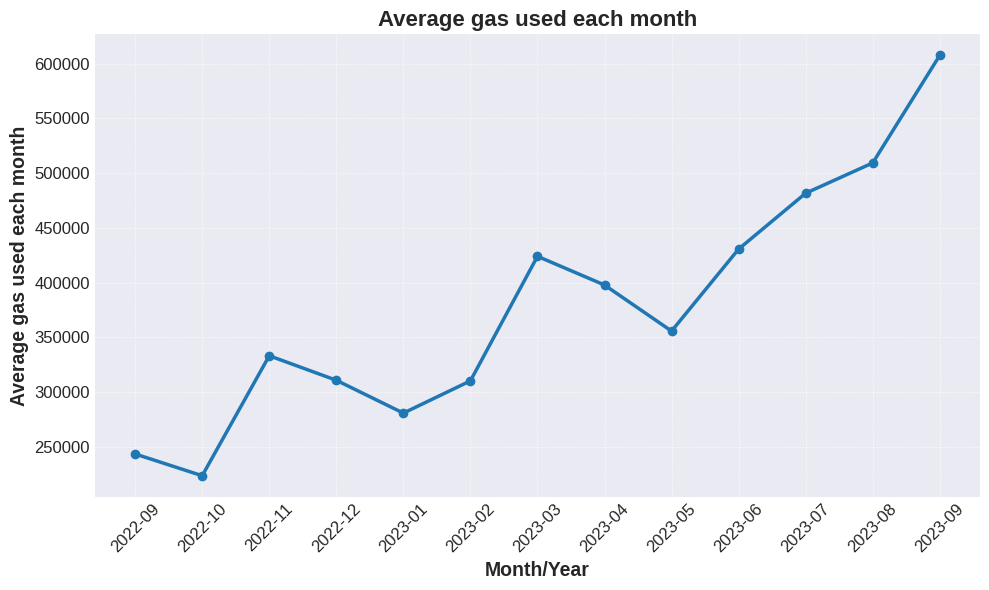

In [56]:
# Setting a style
plt.style.use('seaborn-darkgrid')

# Creating a color palette
palette = plt.get_cmap('tab10')

fig, ax = plt.subplots(figsize=( 10,6))

# Plotting with improved aesthetics
ax.plot(avg_gas_used_rdd_df["Date"], avg_gas_used_rdd_df["Average gas used"], marker='o', color=palette(0), linewidth=2.5)
ax.set_xlabel("Month/Year", fontsize=14, fontweight='bold')
ax.set_ylabel("Average gas used each month", fontsize=14, fontweight='bold')
ax.set_title("Average gas used each month", fontsize=16, fontweight='bold')

# Adding a background grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Setting the font size for tick labels for better visibility
ax.tick_params(axis='both', which='major', labelsize=12)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [58]:
avg_gas_price_rdd_df = pd.DataFrame(avg_gas_price_rdd, columns=["Date", "Average gas Price"])
avg_gas_price_rdd_df['Date'] = avg_gas_price_rdd_df['Date'].apply(lambda x: f"{x[0]}-{x[1]:02}")

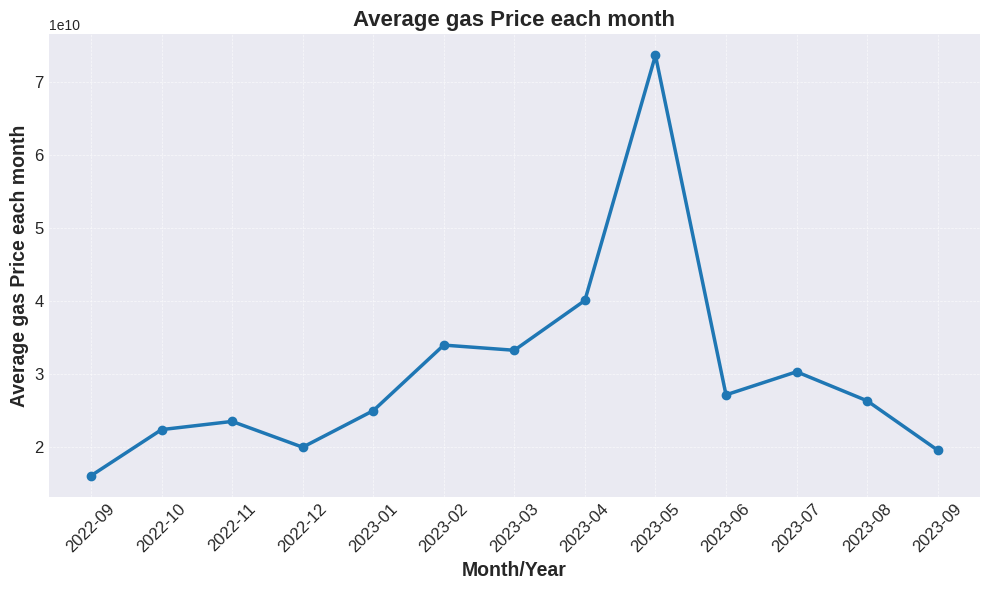

In [60]:
# Setting a style
plt.style.use('seaborn-darkgrid')

# Creating a color palette
palette = plt.get_cmap('tab10')

fig, ax = plt.subplots(figsize=( 10,6))

# Plotting with improved aesthetics
ax.plot(avg_gas_price_rdd_df["Date"], avg_gas_price_rdd_df["Average gas Price"], marker='o', color=palette(0), linewidth=2.5)
ax.set_xlabel("Month/Year", fontsize=14, fontweight='bold')
ax.set_ylabel("Average gas Price each month", fontsize=14, fontweight='bold')
ax.set_title("Average gas Price each month", fontsize=16, fontweight='bold')

# Adding a background grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Setting the font size for tick labels for better visibility
ax.tick_params(axis='both', which='major', labelsize=12)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()